### Set up variables and import libraries

In [23]:
import mymri, pickle, glob, sys, os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc, gridspec
import numpy as np
import nibabel as nb
from nilearn import plotting as nl_plt
from nilearn import surface as nl_surf
from scipy.ndimage import measurements as ms
from matplotlib.ticker import FormatStrFormatter
from os.path import expanduser
home = expanduser("~")
sys.path.append("{0}/code/git/palettable".format(home))
import palettable

from importlib import reload
reload(mymri)

# experiment 1 variables
experiment = ["multicue", "multicueAtt"]
tasks = []
tasks.append({"cont": {"offset": 2},
              "mot": {"offset": 2},
              "disp": {"offset": 8}})
# experiment 2 variables
tasks.append({"motAtt": {"offset": 0},
              "dispAtt": {"offset": 0}})

# harmonic to use
harm = "1"

# do projected
projected = False

# defined in ROI analysis
ring_size = .5

# directories
bids_dir = '/Volumes/Denali_DATA1/kohler/fMRI_EXP/BIDS_ANALYSIS'
fs_dir = '{0}/freesurfer/'.format(bids_dir)
fig_dir =  '{0}/Dropbox/WRITING/Articles/KohlerMultiCue2016/2018_submission/figures/raw'.format(home)

space = 'sumanative'  # 'fsnative'
# saving the objects:
roi_file = "{0}/roi_data_{1}.pkl".format(bids_dir, space)

# p-value cut-off and phase cutoff
alpha = 0.05
phase_cutoff = (4,12,16,24)
cycle_len = 24

plt.close('all')
# define plotting variables
evc_names = ["V1", "V2", "V3"]
fig_labels = ["A", "B", "C"]
from palettable.colorbrewer.qualitative import Paired_10 
from palettable.tableau import Tableau_10, TableauMedium_10, TableauLight_10

cond_colors = [Paired_10.mpl_colors[x] for x in [1, 7, 3]]
roi_colors = [ color for x, color in enumerate(Tableau_10.mpl_colors) if x not in [0,1,2,7] ]
roi_colors.extend( [ color for x, color in enumerate(TableauMedium_10.mpl_colors) if x not in [0,1,2,7] ] )
roi_colors.extend( [ color for x, color in enumerate(TableauLight_10.mpl_colors) if x not in [0,1,2,7] ] )
evc_colors = roi_colors[0:3]
wang_colors = roi_colors[3:]
marker = ["^", "v"]
lwidth = 1.5
plt.rcParams.update(
    {'font.family': 'sans-serif', 'font.sans-serif': ['Arial'], 'font.weight': 'normal', 'font.size': 12,
     'axes.linewidth': lwidth, 'xtick.major.width': lwidth, 'ytick.major.width': lwidth, 'legend.fancybox': False})
save_figs = True

### run ring and Wang ROI individual subject analyses, or simply load the data

In [24]:
# load or run analysis
wang_group = []; ring_group = [];
for e,cur_exp in enumerate(experiment):
    exp_dir = '{0}/{1}/fmriprep'.format(bids_dir,cur_exp)
    wang_group.append(mymri.group_analyze(exp_dir, tasks[e], fs_dir=fs_dir, data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang", overwrite=False))
    ring_group.append(mymri.group_analyze(exp_dir, tasks[e], fs_dir=fs_dir, data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang+benson", overwrite=False))

running group wang analysis ...
    analyzing sub-0011 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0011 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0011 on task disp, pre-tr: 0, offset: 8
    analyzing sub-0014 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0014 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0014 on task disp, pre-tr: 0, offset: 8
    analyzing sub-0016 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0016 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0016 on task disp, pre-tr: 0, offset: 8
    analyzing sub-0022 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0022 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0023 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0023 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0023 on task disp, pre-tr: 0, offset: 8
    analyzing sub-0025 on task cont, pre-tr: 0, offset: 2
    analyzing sub-0025 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0025 on task disp, pre-tr: 0

    analyzing sub-0040 on task dispAtt, pre-tr: 0, offset: 0
    analyzing sub-0043 on task motAtt, pre-tr: 0, offset: 0
    analyzing sub-0043 on task dispAtt, pre-tr: 0, offset: 0
    analyzing sub-0044 on task motAtt, pre-tr: 0, offset: 0
    analyzing sub-0044 on task dispAtt, pre-tr: 0, offset: 0
    analyzing sub-0045 on task motAtt, pre-tr: 0, offset: 0
    analyzing sub-0045 on task dispAtt, pre-tr: 0, offset: 0
    analyzing sub-0047 on task motAtt, pre-tr: 0, offset: 0
    analyzing sub-0047 on task dispAtt, pre-tr: 0, offset: 0
    analyzing sub-0048 on task motAtt, pre-tr: 0, offset: 0
    analyzing sub-0048 on task dispAtt, pre-tr: 0, offset: 0
group analysis complete, task motAtt took 01 seconds
group analysis complete, task dispAtt took 01 seconds


### get number of indices per ROI

In [25]:
wang_names = [roi_name for roi_name in list(wang_group[0]["cont"][harm]["stats"].index) if
              all([r+x+"-BL" not in roi_name for r in evc_names for x in ["d", "v", ""]]) and "BL" in roi_name]
exclude_rois = ["IPS4", "IPS5", "FEF", "TO2"]
wang_names = [x for x in wang_names if all([r not in x for r in exclude_rois])]

import pandas as pd
# wang ROIs
for e, cur_exp in enumerate(experiment):
    for t, task in enumerate(wang_group[e].keys()):   
        bl_names = [name for name in wang_group[e][task]["1"]["stats"].index.values if "BL" in name]
        if t + e == 0:
            wang_info = pd.DataFrame(index=bl_names)
        bl_idx = [num for num, name in enumerate(wang_group[e][task]["1"]["stats"].index.values) if "BL" in name]
        wang_info.at[bl_names, 'subs_{0}'.format(task)] = wang_group[e][task]["1"]["num_subs"][bl_idx]
        wang_info.at[bl_names, 'size_{0}'.format(task)] = [int(x) for x in np.mean(wang_group[e][task]["1"]["roi_size"][:,bl_idx], axis=0)]
# ring ROIs
for e, cur_exp in enumerate(experiment):
    for t, task in enumerate(ring_group[e].keys()):   
        bl_names = [name for name in ring_group[e][task]["1"]["stats"].index.values if "BL" in name]
        if t + e == 0:
            ring_info = pd.DataFrame(index=bl_names)
        bl_idx = [num for num, name in enumerate(ring_group[e][task]["1"]["stats"].index.values) if "BL" in name]
        ring_info.at[bl_names, 'subs_{0}'.format(task)] = ring_group[e][task]["1"]["num_subs"][bl_idx]
        ring_info.at[bl_names, 'size_{0}'.format(task)] = [int(x) for x in np.mean(ring_group[e][task]["1"]["roi_size"][:,bl_idx], axis=0)]
wang_info = wang_info.loc[wang_names]
print(ring_info)
print(wang_info)

            subs_cont  size_cont  subs_mot  size_mot  subs_disp  size_disp  \
V1_0.25-BL         13         79        13        79         11         79   
V1_0.50-BL         15        177        15       177         13        177   
V1_0.75-BL         15        358        15       358         13        358   
V1_1.00-BL         15        450        15       450         13        450   
V1_1.25-BL         15        623        15       623         13        623   
V1_1.50-BL         15        648        15       648         13        648   
V1_1.75-BL         15        490        15       490         13        490   
V1_2.00-BL         15        429        15       429         13        429   
V1_2.25-BL         15        408        15       408         13        408   
V1_2.50-BL         15        399        15       399         13        399   
V1_2.75-BL         15        380        15       380         13        380   
V1_3.00-BL         15        364        15       364         13 

### run wang group analyses

/Users/kohler/anaconda2/envs/py37/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


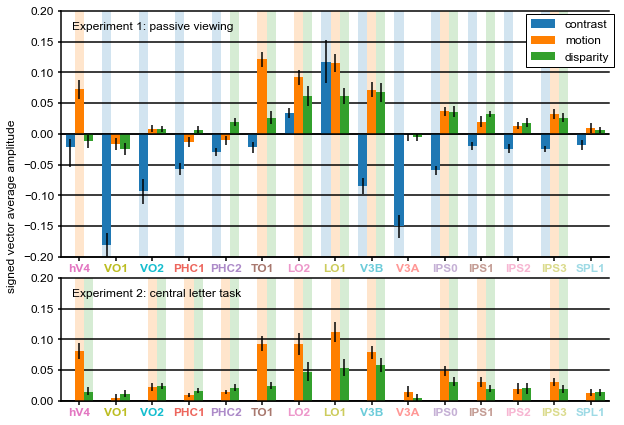

In [26]:
make_blank = False
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
# Turn off axis lines and ticks of the big subplot
[ax.spines[x].set_color('none') for x in ax.spines.keys()]
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_ylabel(u'signed vector average amplitude')
ax.yaxis.set_label_coords(-0.08, .5)
bar_locs = [-1, 0, 1]
wang_results = {}
wang_reject = []
for e, cur_exp in enumerate(experiment):
    num_tasks = len(wang_group[e].keys())
    p_h = [None] * num_tasks
    sub_ax = fig.add_subplot(gs[e])
    wang_results[cur_exp] = {}
    for task in wang_group[e].keys():
        if "cont" in task:
            t = 0
        elif "mot" in task:
            t = 1
        elif "disp" in task:
            t = 2
        wang_results[cur_exp][task] = {k: [] for k in ["amp", "lo_err", "hi_err", "tval", "pval", "cut_reject"]}
        temp_amp = np.squeeze(np.asarray([ wang_group[e][task][harm]["stats"].loc[x,"amp_mu"] for x in wang_names ] ))
        temp_phase = np.squeeze(np.asarray( [ wang_group[e][task][harm]["stats"].loc[x,"ph_mu"] for x in wang_names ] ))
        temp_phase = np.mod(temp_phase/(2*np.pi) * cycle_len + 1, cycle_len) # add 1 to account for slice-timing 
        if projected:
            temp_err = np.squeeze(np.asarray( [ wang_group[e][task][harm]["stats"].loc[x,"proj_err"] for x in wang_names ] ))
            temp_err = np.repeat(temp_err.reshape(-1,1),2,1)
            temp_stats = np.squeeze(np.asarray( [ wang_group[e][task][harm]["stats"].loc[x,"ttest_1s"] for x in wang_names ] ))
        else:
            temp_err = np.squeeze(np.asarray([ wang_group[e][task][harm]["stats"].loc[x,"el_err_amp"] for x in wang_names ] ))
            temp_stats = np.squeeze(np.asarray([ wang_group[e][task][harm]["stats"].loc[x,"hotT2"] for x in wang_names ] ))
        # phase bigger than pi, B block response
        # subtract 2 seconds to correct to consider responses immediately after the onset part of the last plot 
        phase_mask = np.mod(temp_phase - 2, cycle_len) > cycle_len/2
        wang_results[cur_exp][task]["amp"] = np.copy(temp_amp)
        wang_results[cur_exp][task]["lo_err"] = np.copy(temp_err[:, 0])
        wang_results[cur_exp][task]["hi_err"] = np.copy(temp_err[:, 1])
        # switch upper and lower error bars, because values are negative
        if phase_mask.any():
            wang_results[cur_exp][task]["amp"][phase_mask] = np.multiply(np.copy(temp_amp[phase_mask]), -1)
            wang_results[cur_exp][task]["lo_err"][phase_mask] = np.copy(temp_err[phase_mask, 1])
            wang_results[cur_exp][task]["hi_err"][phase_mask] = np.copy(temp_err[phase_mask, 0])

        wang_results[cur_exp][task]["tval"] = np.copy(temp_stats[:, 0])
        wang_results[cur_exp][task]["pval"] = np.copy(temp_stats[:, 1])
        wang_results[cur_exp][task]["cut_reject"] = np.zeros_like(temp_stats[:, 1])
        sig_idx = np.transpose(np.where(temp_stats[:, 1] < alpha))

        for n in sig_idx:
            #if not ((temp_phase[n] > np.pi + phase_cutoff and temp_phase[n] < np.pi * 2 - phase_cutoff) or
            #        (temp_phase[n] < np.pi - phase_cutoff and temp_phase[n] > phase_cutoff)):
            if not ((temp_phase[n] > phase_cutoff[0] and temp_phase[n] < phase_cutoff[1]) or
                    (temp_phase[n] > phase_cutoff[2] and temp_phase[n] < phase_cutoff[3])):
                wang_results[cur_exp][task]["tval"][n] = 0
                wang_results[cur_exp][task]["pval"][n] = 1
                wang_results[cur_exp][task]["cut_reject"][n] = 1
        x_ticks = [x * 4 for x in range(0, temp_amp.shape[0])]
        x_lims = (np.min(x_ticks) - 2, np.max(x_ticks) + 2)
        y_lims = (-.2 + e * .2, .2)

        # start plotting
        wang_x = [x * 4 + bar_locs[t] for x in range(0, temp_amp.shape[0])]
        
        if not make_blank:
            p_h[t - e] = plt.bar(wang_x, wang_results[cur_exp][task]["amp"], linewidth=lwidth, width=1, edgecolor=None,
                                 color=cond_colors[t], clip_on=False, zorder=3)
            e_h = plt.errorbar(wang_x, wang_results[cur_exp][task]["amp"],
                               (wang_results[cur_exp][task]["lo_err"], wang_results[cur_exp][task]["hi_err"]),
                               ecolor="black", fmt="none", elinewidth=lwidth, clip_on=False, zorder=4)
            # find significant regions
            sig_regions, num_regions = ms.label(np.asarray(wang_results[cur_exp][task]["pval"]) < alpha)
            for n, sig in enumerate(sig_regions):
                if sig > 0:
                    patch_min = wang_x[n] - .5
                    patch_max = wang_x[n] + .5
                    pgon = plt.Polygon(
                        [[patch_min, y_lims[0]], [patch_min, y_lims[1]], [patch_max, y_lims[1]], [patch_max, y_lims[0]]],
                        facecolor=cond_colors[t], edgecolor="None", alpha=0.2, zorder=-2)
                    sub_ax.add_patch(pgon)
    plt.xlim(x_lims)
    plt.ylim(y_lims)
    plt.xticks(x_ticks, [x[:-3] for x in wang_names])
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), wang_colors):
        ticklabel.set_color(tickcolor)
        ticklabel.set_weight("bold")
    [sub_ax.spines[x].set_visible(False) for x in ["top", "right"]]
    plt.plot([-100, 100], np.zeros(2) * 2, '-', color='black', linewidth=lwidth, zorder=99)
    plt.grid(True, axis="y", zorder=0, color="black", linewidth=lwidth, clip_on=False)
    label_pos = plt.xlim()[0] + np.diff(plt.xlim()) * .02
    if e == 0:
        if not make_blank:
            sub_ax.legend([x[0] for x in p_h], ["contrast", "motion", "disparity"], framealpha=1, facecolor='white',
                          edgecolor='black', loc='upper right', bbox_to_anchor=(1.02, 1.01))
        plt.text(label_pos, np.mean(plt.yticks()[0][-2:]), "Experiment 1: passive viewing", fontsize=12, color="black",
                 horizontalalignment="left", verticalalignment="center", )
    else:
        plt.text(label_pos, np.mean(plt.yticks()[0][-2:]), "Experiment 2: central letter task", fontsize=12,
                 color="black", horizontalalignment="left", verticalalignment="center", )
    # find number of significant regions rejected due to cut off
    wang_reject.append( [ sum(wang_results[cur_exp][x]["cut_reject"]) for x in wang_group[e].keys() ] )
plt.tight_layout(h_pad=0, w_pad=-1, pad=0)
plt.draw()
if save_figs:
    if make_blank:
        plt.savefig("{0}/wang_plot_exp_blank.pdf".format(fig_dir), format="pdf", dpi=1000, bbox_inches='tight')
    else:
        plt.savefig("{0}/wang_plot_exp.pdf".format(fig_dir), format="pdf", dpi=1000, bbox_inches='tight')
plt.show(fig)

### run ring group analyses

0.06344766145993352


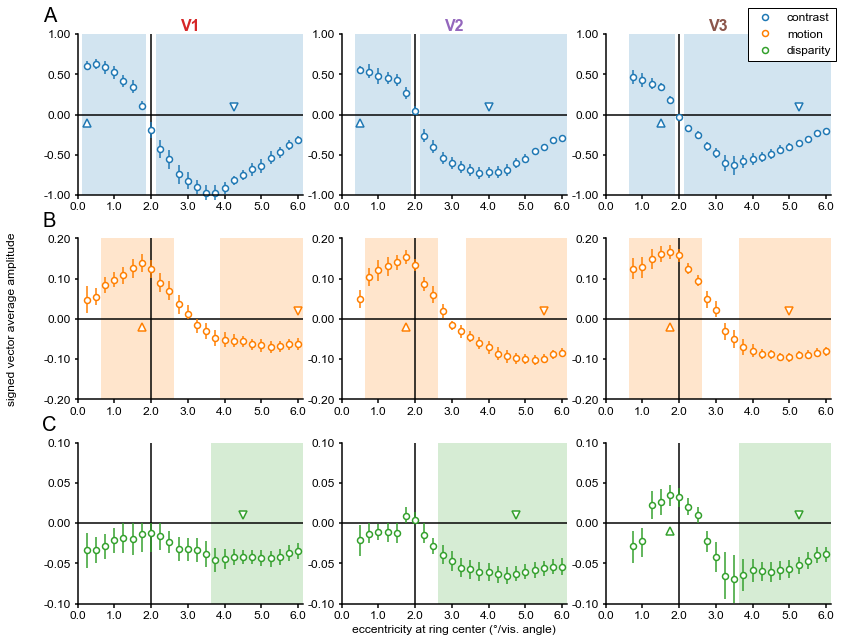

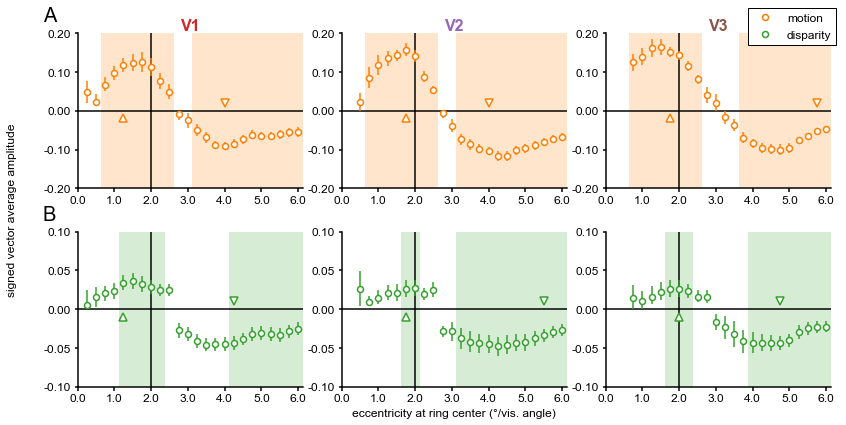

In [27]:
zero_idx = 99
ring_results = {}
for e, cur_exp in enumerate(experiment):
    num_tasks = len(ring_group[e].keys())
    fig = plt.figure(figsize=(12, 3 * num_tasks))
    ax = fig.add_subplot(111)
    # Turn off axis lines and ticks of the big subplot
    [ax.spines[x].set_color('none') for x in ax.spines.keys()]
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_ylabel(u'signed vector average amplitude')
    ax.yaxis.set_label_coords(-0.08, .5)
    p_h = [None] * num_tasks
    y_lims = [(-1,1), (-.2,.2), (-.1,.1) ]
    y_units = [.5, .1, .05]
    ring_results[cur_exp] = {}
    for task in ring_group[e].keys():
        ring_results[cur_exp][task] = {}
        for r, roi in enumerate(evc_names):
            if "cont" in task:
                t = 0
            elif "mot" in task:
                t = 1
            elif "disp" in task:
                t = 2

            # plot data
            sub_ax = fig.add_subplot(num_tasks, len(evc_names), r + 1 + (t - e) * len(evc_names))
            if t - e == 0: leg_ax = sub_ax  # somewhat annoying, to make sure legends are plotted on the first row            
            ring_names = [roi_name for roi_name in list(ring_group[e][task][harm]["stats"].index) if roi in roi_name and "BL" in roi_name]

            ring_results[cur_exp][task][roi] = {k: [] for k in ["rois", "amp", "lo_err", "hi_err", "tval", "pval", "cut_reject"]}
            temp_amp = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x,"amp_mu"] for x in ring_names ] ))
            temp_phase = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x, "ph_mu"] for x in ring_names ] ))
            temp_phase = np.mod(temp_phase/(2*np.pi) * cycle_len + 1, cycle_len) # add 1 to account for slice-timing 
            if projected:
                temp_err = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x,"proj_err"] for x in ring_names ] ))
                temp_err = np.repeat(temp_err.reshape(-1,1),2,1)
                temp_stats = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x,"ttest_1s"] for x in ring_names ] ))
            else:
                temp_err = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x,"el_err_amp"] for x in ring_names ] ))
                temp_stats = np.squeeze(np.asarray([ ring_group[e][task][harm]["stats"].loc[x,"hotT2"] for x in ring_names ] ))
            temp_cycle_ave = np.squeeze(np.asarray([ ring_group[e][task][harm]["cycle"].loc[x,"ave"] for x in ring_names ] ))
            temp_cycle_err = np.squeeze(np.asarray([ ring_group[e][task][harm]["cycle"].loc[x,"stderr"] for x in ring_names ] ))
            
            # phase bigger than pi, B block response
            # subtract 2 seconds to correct to consider responses immediately after the onset part of the last plot 
            phase_mask = np.mod(temp_phase - 2, cycle_len) > cycle_len/2
            ring_results[cur_exp][task][roi]["amp"] = np.copy(temp_amp)
            ring_results[cur_exp][task][roi]["lo_err"] = np.copy(temp_err[:, 0])
            ring_results[cur_exp][task][roi]["hi_err"] = np.copy(temp_err[:, 1])
            # switch upper and lower error bars, because values are negative
            if phase_mask.any():
                ring_results[cur_exp][task][roi]["amp"][phase_mask] = np.multiply(np.copy(temp_amp[phase_mask]), -1)
                ring_results[cur_exp][task][roi]["lo_err"][phase_mask] = np.copy(temp_err[phase_mask, 1])
                ring_results[cur_exp][task][roi]["hi_err"][phase_mask] = np.copy(temp_err[phase_mask, 0])

            ring_results[cur_exp][task][roi]["tval"] = np.copy(temp_stats[:, 0])
            ring_results[cur_exp][task][roi]["pval"] = np.copy(temp_stats[:, 1])
            ring_results[cur_exp][task][roi]["cut_reject"] = np.zeros_like(temp_stats[:, 1])
            
            sig_idx = np.transpose(np.where(temp_stats[:, 1] < alpha))
            for n in sig_idx:
                #if not ((temp_phase[n] > np.pi + phase_cutoff and temp_phase[n] < np.pi * 2 - phase_cutoff) or
                #        (temp_phase[n] < np.pi - phase_cutoff and temp_phase[n] > phase_cutoff)):
                if not ((temp_phase[n] > phase_cutoff[0] and temp_phase[n] < phase_cutoff[1]) or
                    (temp_phase[n] > phase_cutoff[2] and temp_phase[n] < phase_cutoff[3])):
                    ring_results[cur_exp][task][roi]["tval"][n] = 0
                    ring_results[cur_exp][task][roi]["pval"][n] = 1
                    ring_results[cur_exp][task][roi]["cut_reject"][n] = 1

            x_vals = [float(x[3:-3]) for x in ring_names]
            # 0 for positive, 1 for negative
            cycle_mask = np.asarray([ int(x < 0) for x in ring_results[cur_exp][task][roi]["amp"] ])
            arrow_loc = [-0.1 * y_lims[t][1], 0.1 * y_lims[t][1]]
            ring_results[cur_exp][task][roi]["cycle_ave"] = np.zeros((temp_cycle_ave.shape[1], 2))
            ring_results[cur_exp][task][roi]["cycle_err"] = np.zeros((temp_cycle_ave.shape[1], 2))
            ring_results[cur_exp][task][roi]["cycle_phase"] = np.zeros(2)
            ring_results[cur_exp][task][roi]["ring_names"] = ["none", "none"]
            ring_results[cur_exp][task][roi]["rois"] = ring_names
            for z in range(2):
                if z in cycle_mask:
                    subset_idx = np.argmax(np.asarray(ring_results[cur_exp][task][roi]["tval"])[cycle_mask == z])
                    cycle_idx = np.arange(len(ring_results[cur_exp][task][roi]["tval"]))[cycle_mask == z][subset_idx]
                    if ring_results[cur_exp][task][roi]["pval"][cycle_idx] < alpha or roi == "V3":
                        if ring_results[cur_exp][task][roi]["pval"][cycle_idx] > alpha:
                            print(ring_results[cur_exp][task][roi]["pval"][cycle_idx])
                        ring_results[cur_exp][task][roi]["cycle_ave"][:, z] = np.copy(temp_cycle_ave[cycle_idx, :].flatten())
                        if np.any(temp_cycle_err[cycle_idx, :].flatten() == 0):
                            zero_idx = cycle_idx
                        ring_results[cur_exp][task][roi]["cycle_err"][:, z] = np.copy(temp_cycle_err[cycle_idx, :].flatten())
                        ring_results[cur_exp][task][roi]["cycle_phase"][z] = np.copy(temp_phase[cycle_idx])
                        ring_results[cur_exp][task][roi]["ring_names"][z] = ring_names[cycle_idx]
                        plt.plot(x_vals[cycle_idx], arrow_loc[z], marker[z], linewidth=lwidth,
                                 markeredgecolor=cond_colors[t], markerfacecolor="white", markeredgewidth=lwidth,
                                 markersize=8, clip_on=False)

            plt.plot(np.ones(2) * 2, [-60, 60], '-', color='black', linewidth=lwidth, zorder=-1)
            plt.plot([-10, 10], np.zeros(2) * 2, '-', color='black', linewidth=lwidth, zorder=-1)
            p_h[t - e] = plt.plot(x_vals, ring_results[cur_exp][task][roi]["amp"], 'o', linewidth=lwidth, markeredgecolor=cond_colors[t],
                                  markerfacecolor="white", markeredgewidth=lwidth, markersize=6,clip_on=False)
            e_h = plt.errorbar(x_vals, ring_results[cur_exp][task][roi]["amp"], [ring_results[cur_exp][task][roi]["lo_err"], ring_results[cur_exp][task][roi]["hi_err"]],
                               ecolor=cond_colors[t], fmt="none", elinewidth=lwidth, clip_on=False)
            for b in e_h[2]:
                b.set_clip_on(False)
            plt.ylim(y_lims[t])
            plt.yticks(np.linspace(y_lims[t][0], y_lims[t][1], 5, endpoint=True))
            #x_lims = ( np.min([float(x) for x in x_vals]) - ring_size / 4, np.max([float(x) for x in x_vals]) + ring_size / 4 )
            x_lims = ( 0 , np.max([float(x) for x in x_vals]) + ring_size / 4 )
            plt.xlim(x_lims)
            plt.xticks(range(0, 7))
            if t - e == 0:
                x_center = plt.xlim()[0] + np.diff(plt.xlim()) / 2
                plt.text(x_center, plt.yticks()[0][-1:], evc_names[r], weight="bold",fontsize=16, color=evc_colors[r],
                         horizontalalignment="center", verticalalignment="bottom")
            if r == 0:
                plt.text(plt.xlim()[0] - x_center * .25, plt.yticks()[0][-1:] * 1.1, fig_labels[t - e], fontsize=20,
                         color="black",
                         horizontalalignment="center", verticalalignment="bottom")
            elif r == 1:
                if t == 2:
                    sub_ax.set_xlabel('eccentricity at ring center (\u00B0/vis. angle)')
            # find significant regions
            sig_regions, num_regions = ms.label(np.asarray(ring_results[cur_exp][task][roi]["pval"]) < alpha)
            for n in np.unique(sig_regions):
                if n > 0:
                    idx_list = [x for x, y in enumerate(sig_regions) if y == n]
                    patch_min = [float(x) for x in x_vals][np.min(idx_list)] - ring_size / 4
                    patch_max = [float(x) for x in x_vals][np.max(idx_list)] + ring_size / 4
                    pgon = plt.Polygon(
                        [[patch_min, y_lims[t][0]], [patch_min, y_lims[t][1]], [patch_max, y_lims[t][1]], [patch_max, y_lims[t][0]]],
                        facecolor=cond_colors[t], edgecolor="None", alpha=0.2, zorder=-2)
                    sub_ax.add_patch(pgon)

            sub_ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            sub_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            [sub_ax.spines[x].set_visible(False) for x in ["top", "right"]]
            sub_ax.grid(False)
    if e == 0:
        leg_labels = ["contrast", "motion", "disparity"]
    else:
        leg_labels = ["motion", "disparity"]
    leg_ax.legend([x[0] for x in p_h], leg_labels, framealpha=1, facecolor='white', edgecolor='black',
                  loc='upper right', bbox_to_anchor=(1.05, 1.2))
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)
    plt.draw()
    if save_figs:
        plt.savefig("{0}/ring_plot_exp{1}.pdf".format(fig_dir,e + 1), format="pdf", dpi=1000, bbox_inches='tight')
    plt.show(fig)
    

In [28]:
for e, cur_exp in enumerate(experiment):
    for task in ring_group[e].keys():
        wang_reject = [ wang_names[x] for x, val in enumerate(wang_results[cur_exp][task]["cut_reject"]) if val == 1]
        if not wang_reject:
            wang_reject = "no"
        evc_reject = []
        for r, roi in enumerate(evc_names):
            if ring_results[cur_exp][task][roi]["cut_reject"].any():
                [evc_reject.append(ring_results[cur_exp][task][roi]["rois"][x]) for x, val in enumerate(ring_results[cur_exp][task][roi]["cut_reject"]) if val == 1]
        if not evc_reject:
            evc_reject = "no"
        print("{0}, task {1}: {2} wang cut off, {3} evc cut off".format(cur_exp, task, wang_reject, evc_reject))
            

multicue, task cont: ['LO2-BL'] wang cut off, no evc cut off
multicue, task mot: no wang cut off, no evc cut off
multicue, task disp: no wang cut off, no evc cut off
multicueAtt, task motAtt: no wang cut off, no evc cut off
multicueAtt, task dispAtt: no wang cut off, ['V1_2.50-BL', 'V1_2.75-BL', 'V1_3.00-BL', 'V1_3.25-BL', 'V1_3.50-BL', 'V1_3.75-BL', 'V1_4.00-BL', 'V2_2.75-BL'] evc cut off


### make cycle average plots for early visual cortex ROIs

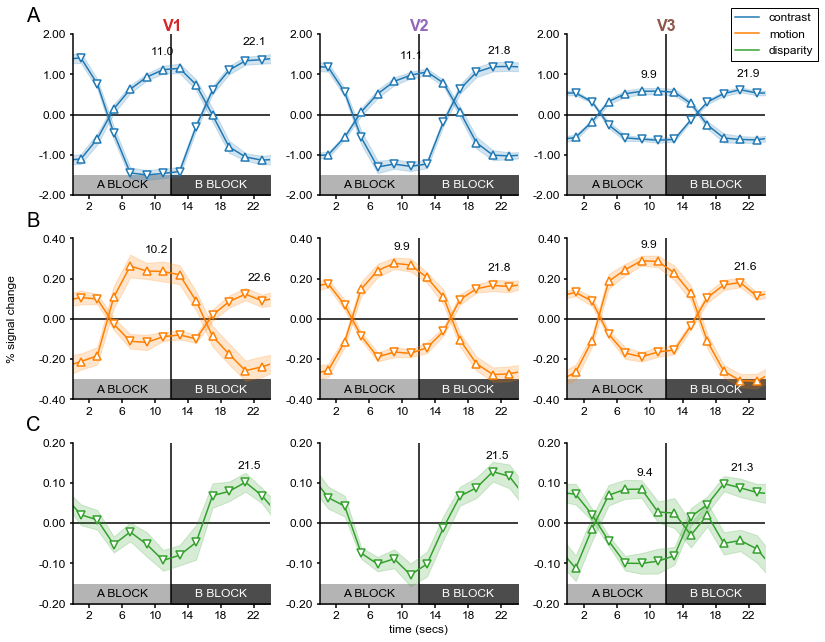

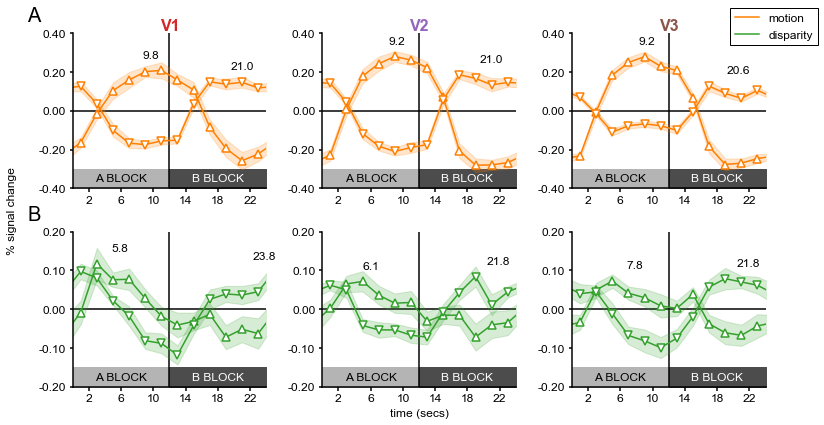

In [29]:
make_blank = False
y_lims = [(-1,1), (-.2,.2), (-.1,.1) ]
for e, cur_exp in enumerate(experiment):
    # run analysis
    # draw cycle plot
    num_tasks = len(ring_group[e].keys())
    fig = plt.figure(figsize=(12, 3 * num_tasks))
    ax = fig.add_subplot(111)
    # Turn off axis lines and ticks of the big subplot
    [ax.spines[x].set_color('none') for x in ax.spines.keys()]
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_ylabel(u'% signal change')
    ax.yaxis.set_label_coords(-0.08, .5)
    p_h = [None] * num_tasks
    for task in ring_group[e].keys():
        for r, roi in enumerate(evc_names):
            if "cont" in task:
                t = 0
            elif "mot" in task:
                t = 1
            elif "disp" in task:
                t = 2
            sub_ax = fig.add_subplot(num_tasks, len(evc_names), r + 1 + (t - e) * len(evc_names))
            if t - e == 0: leg_ax = sub_ax  # somewhat annoying, to make sure legends are plotted on the first row
            cycle_x = np.linspace(-1, 25, 14)
            plt.xlim((0, 24))
            plt.ylim((-y_lims[t][1] * 2, y_lims[t][1] * 2))
            x_center = 12
            plt.xticks([2, 6, 10, 14, 18, 22])
            plt.yticks(np.linspace(plt.ylim()[0],plt.ylim()[1],5))
            block_y = (np.ones((2)) * plt.yticks()[0][0], np.ones((2)) * np.mean(plt.yticks()[0][:2]))
            plt.fill_between([0, 12], block_y[0], block_y[1], color="{0}".format(180 / 255), alpha=1, clip_on=False,
                             zorder=-2)
            plt.fill_between([12, 24], block_y[0], block_y[1], color="{0}".format(76 / 255), alpha=1, clip_on=False,
                             zorder=-2)
            plt.text(x_center * .5, np.mean(block_y), 'A BLOCK', fontsize=12, color="black",
                     horizontalalignment="center", verticalalignment="center")
            plt.text(x_center * 1.5, np.mean(block_y), 'B BLOCK', fontsize=12, color="white",
                     horizontalalignment="center", verticalalignment="center")
            plt.plot(np.ones(2) * x_center, [-2, 2], '-', color='black', linewidth=lwidth, zorder=-1)
            plt.plot([0, 25], np.zeros(2) * 2, '-', color='black', linewidth=lwidth, zorder=-1)
            for z in range(2):
                if any(ring_results[cur_exp][task][roi]["cycle_ave"][:, z] > 0):
                    cur_cycle = np.vstack((ring_results[cur_exp][task][roi]["cycle_ave"][:, z], ring_results[cur_exp][task][roi]["cycle_err"][:, z]))
                    new_cycle = np.hstack((cur_cycle, np.tile(cur_cycle[:, [0]], 1)))
                    new_cycle = np.hstack((np.tile(cur_cycle[:, [-1]], 1), new_cycle))
                    cur_cycle = new_cycle
                    plt.fill_between(cycle_x, cur_cycle[0, :] - cur_cycle[1, :], cur_cycle[0, :] + cur_cycle[1, :],
                                     color=cond_colors[t], alpha=0.2, clip_on=True, visible=not make_blank)
                    p_h[t - e] = plt.plot(cycle_x, cur_cycle[0, :], color=cond_colors[t], visible=not make_blank, clip_on=True,
                                          linewidth=lwidth)
                    plt.plot(cycle_x[1:-1], cur_cycle[0, 1:-1], marker[z], color=cond_colors[t], markersize=8,
                             markeredgecolor=cond_colors[t], markerfacecolor="white", markeredgewidth=lwidth, visible=not make_blank,
                             clip_on=False)
                    if not make_blank:
                        ph_y = np.max(cur_cycle[0, 1:-1]) + plt.ylim()[1]*.2  
                        ph_x = ring_results[cur_exp][task][roi]["cycle_phase"][z] 
                        plt.text(ph_x, ph_y,
                                 "{:.1f}".format(ring_results[cur_exp][task][roi]["cycle_phase"][z]), 
                                 fontsize=12, color="black", horizontalalignment="center", verticalalignment="center")


            sub_ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            sub_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            sub_ax.spines['top'].set_visible(False)
            sub_ax.spines['right'].set_visible(False)
            sub_ax.grid(False)
            if t - e == 0:
                plt.text(x_center, plt.yticks()[0][-1:], evc_names[r], weight="bold",fontsize=16, color=evc_colors[r],
                         horizontalalignment="center", verticalalignment="bottom")
            if r == 0:
                plt.text(plt.xlim()[0] - x_center * .4, plt.yticks()[0][-1:] * 1.1, fig_labels[t - e], fontsize=20,
                         color="black", horizontalalignment="center", verticalalignment="bottom")
            elif r == 1:
                if t == 2:
                    sub_ax.set_xlabel('time (secs)')
    if e == 0:
        leg_labels = ["contrast", "motion", "disparity"]
    else:
        leg_labels = ["motion", "disparity"]
    leg_ax.legend([x[0] for x in p_h], leg_labels, framealpha=1, facecolor='white', edgecolor='black',
                  loc='upper right', bbox_to_anchor=(1.3, 1.2))
    plt.tight_layout(h_pad=0, w_pad=1, pad=0)
    plt.draw()
    if save_figs:
        if make_blank:
            plt.savefig("{0}/ring_cycle_exp{1}_blank.pdf".format(fig_dir, e + 1), format="pdf", dpi=1000,
                    bbox_inches='tight')
        else:
            plt.savefig("{0}/ring_cycle_exp{1}.pdf".format(fig_dir, e + 1), format="pdf", dpi=1000,
                    bbox_inches='tight')
    plt.show(fig)
    

## Do individual subject real vs imaginary plots

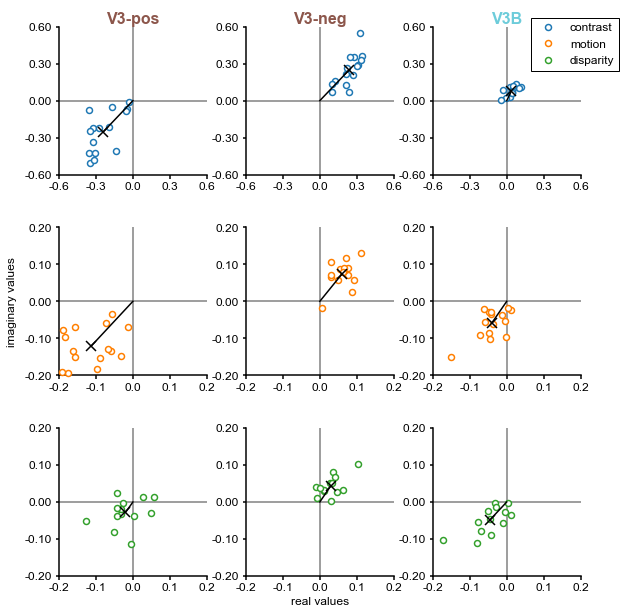

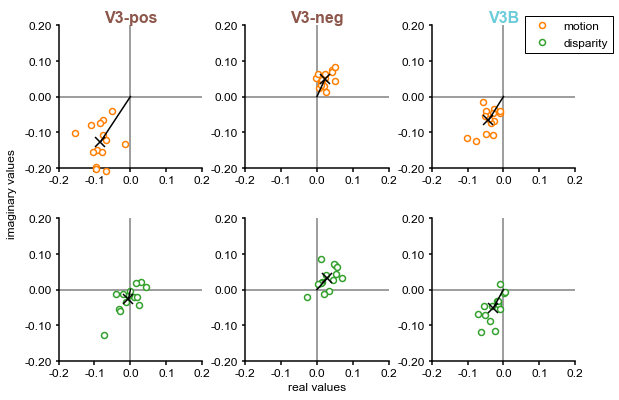

In [30]:
y_lims = [(-.6,.6), (-.2,.2), (-.2,.2) ]
titles = ['V3-pos','V3-neg','V3B']
for e, cur_exp in enumerate(experiment):
    num_tasks = len(ring_group[e].keys())
    p_h = [None] * num_tasks
    fig = plt.figure(figsize=(9, 3 * num_tasks))
    ax = fig.add_subplot(111)
    # Turn off axis lines and ticks of the big subplot
    [ax.spines[x].set_color('none') for x in ax.spines.keys()]
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    ax.set_ylabel('imaginary values')
    ax.yaxis.set_label_coords(-0.08, .5)
    for task in ring_group[e].keys():
        if "cont" in task:
            t = 0
        elif "mot" in task:
            t = 1
        elif "disp" in task:
            t = 2
        for z in range(3):
            sub_ax = fig.add_subplot(num_tasks, 3, z + 1 + (t - e) * 3)
            if t - e == 0: leg_ax = sub_ax  # somewhat annoying, to make sure legends are plotted on the first row
            if z <= 1:
                idx_name = ring_results[cur_exp][task]["V3"]["ring_names"][z]
                real_vals = np.real(ring_group[e][task][harm]["stats"].loc[idx_name,"sub_complex"])
                imag_vals = np.imag(ring_group[e][task][harm]["stats"].loc[idx_name,"sub_complex"])
                cur_color = evc_colors[2]
            else:
                idx_name = 'V3B-BL'
                real_vals = np.real(wang_group[e][task][harm]["stats"].loc[idx_name,"sub_complex"])
                imag_vals = np.imag(wang_group[e][task][harm]["stats"].loc[idx_name,"sub_complex"])
                cur_color = wang_colors[8]
            
            real_avg = np.nanmean(real_vals)
            imag_avg = np.nanmean(imag_vals)   
            p_h[t - e] = plt.plot(real_vals, imag_vals,'o', linewidth=lwidth, markeredgecolor=cond_colors[t],
                                          markerfacecolor="white", markeredgewidth=lwidth, markersize=6,clip_on=False, zorder=99)
            plt.plot([0, real_avg], [0, imag_avg] ,'-', linewidth=lwidth, color="black", markersize=6,clip_on=False, zorder=99) 
            plt.plot(real_avg, imag_avg ,'x', linewidth=lwidth, color="black",markeredgewidth=lwidth, markersize=10,clip_on=False, zorder=99) 
            plt.xlim(y_lims[t])
            plt.ylim(y_lims[t])
            plt.plot(np.zeros(2), [-1, 1], '-', color='gray', linewidth=lwidth, zorder=-1)
            plt.plot([-1, 1], np.zeros(2), '-', color='gray', linewidth=lwidth, zorder=-1)
            plt.xticks(np.linspace(y_lims[t][0], y_lims[t][1],5))
            plt.yticks(np.linspace(y_lims[t][0], y_lims[t][1],5))
            x_center = plt.xlim()[0] + np.diff(plt.xlim()) / 2
            if (t - e) == 0:
                plt.text(x_center, plt.yticks()[0][-1:], titles[z], weight="bold",fontsize=16, color=cur_color,
                         horizontalalignment="center", verticalalignment="bottom")
            if z == 1 and t==2:
                sub_ax.set_xlabel('real values')
            plt.gca().set_aspect('equal', adjustable='box')
            sub_ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            sub_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            [sub_ax.spines[x].set_visible(False) for x in ["top", "right"]]
            sub_ax.grid(False)
    if e == 0:
        leg_labels = ["contrast", "motion", "disparity"]
    else:
        leg_labels = ["motion", "disparity"]
    leg_ax.legend([x[0] for x in p_h], leg_labels, framealpha=1, facecolor='white', edgecolor='black',
                  loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)
    plt.draw()
    if save_figs:
        plt.savefig("{0}/subject_plot_exp{1}.pdf".format(fig_dir, e + 1), format="pdf", dpi=1000, bbox_inches='tight')


### Do ROI comparisons

In [31]:
comp_dir = [ '{0}/{1}/fmriprep'.format(bids_dir,x) for x in experiment ]
comp_tasks = [{"mot": tasks[0]["mot"]},{"motAtt":tasks[1]["motAtt"]}]
mot_wang_comp = mymri.group_compare(comp_dir, tasks=comp_tasks, fs_dir=fs_dir, subjects='All', data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang", harmonic_list=[1], test_type = "hot_ind", report_timing=True, overwrite=False)
mot_ring_comp = mymri.group_compare(comp_dir, tasks=comp_tasks, fs_dir=fs_dir, subjects='All', data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang+benson", harmonic_list=[1], test_type = "hot_ind", report_timing=True, overwrite=False)
comp_tasks = [{"disp": tasks[0]["disp"]},{"dispAtt":tasks[1]["dispAtt"]}]
disp_wang_comp = mymri.group_compare(comp_dir, tasks=comp_tasks, fs_dir=fs_dir, subjects='All', data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang", harmonic_list=[1], test_type = "hot_ind", report_timing=True, overwrite=False)
disp_ring_comp = mymri.group_compare(comp_dir, tasks=comp_tasks, fs_dir=fs_dir, subjects='All', data_spec={"space": "sumanative", "detrending": True, "scaling": True, "smoothing": 0}, roi_type="wang+benson", harmonic_list=[1], test_type = "hot_ind", report_timing=True, overwrite=False)

running group comparison, independent samples, wang rois, 1 harmonic[s] ...
    analyzing sub-0011 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0014 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0016 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0022 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0023 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0025 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0027 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0028 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0032 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0033 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0034 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0035 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0037 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0039 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0040 on task mot, pre-tr: 0, offset: 2
    analyzing sub-0011 on task motAtt, pre-tr: 0, offset: 0
    analy

In [32]:
import pandas as pd
compare = "motion"
comp_alpha = 0.05
cur_rois = ring_names
comp_frame = pd.DataFrame(columns=['roi-name','amp1', 'amp2', 'hot_t', 'p-val'])
# do ring
for r, roi in enumerate(evc_names):
    cur_names = ring_results[experiment[0]]["cont"][roi]["rois"]
    if "motion" in compare:
        cur_comp = mot_ring_comp
        amp1 = ring_results[experiment[0]]["mot"][roi]["amp"]
        amp2 = ring_results[experiment[1]]["motAtt"][roi]["amp"]
    else:
        cur_comp = disp_ring_comp
        amp1 = ring_results[experiment[0]]["disp"][roi]["amp"]
        amp2 = ring_results[experiment[1]]["dispAtt"][roi]["amp"]
    comp_results = [(name, amp1[idx], amp2[idx],
                             cur_comp[harm]["stats"].loc[name,"hotT2"][0], 
                             cur_comp[harm]["stats"].loc[name,"hotT2"][1] ) 
                    for idx, name in enumerate(cur_names) if cur_comp[harm]["stats"].loc[name,"hotT2"][1] < comp_alpha]
    comp_frame = pd.concat([comp_frame,pd.DataFrame(data=comp_results ,columns=['roi-name','amp1', 'amp2', 'hot_t', 'p-val'])],ignore_index=True)

# do wang
cur_names = wang_names
if "motion" in compare:
    cur_comp = mot_wang_comp
    amp1 = wang_results[experiment[0]]["mot"]["amp"]
    amp2 = wang_results[experiment[1]]["motAtt"]["amp"]
else:
    cur_comp = disp_wang_comp
    amp1 = wang_results[experiment[0]]["disp"]["amp"]
    amp2 = wang_results[experiment[1]]["dispAtt"]["amp"]
comp_results = [(name, amp1[idx], amp2[idx],
                         cur_comp[harm]["stats"].loc[name,"hotT2"][0], 
                         cur_comp[harm]["stats"].loc[name,"hotT2"][1] ) for idx, name in enumerate(cur_names) if cur_comp[harm]["stats"].loc[name,"hotT2"][1] < comp_alpha]
comp_frame = pd.concat([comp_frame,pd.DataFrame(data=comp_results ,columns=['roi-name','amp1', 'amp2', 'hot_t', 'p-val'])],ignore_index=True)
comp_frame.set_index("roi-name")

,amp1,amp2,hot_t,p-val
roi-name,,,,
V1_5.50-BL,-0.068534,-0.061111,4.238111,0.025521
V1_5.75-BL,-0.063053,-0.056091,6.411036,0.005453
V1_6.00-BL,-0.062294,-0.053950,7.625305,0.002478
PHC2-BL,-0.010852,0.014746,3.532941,0.043925


### run whole brain analysis  or load the data     


In [33]:
# load or run analysis
run_whole = False
smooth_level = 3
whole_file = "{0}/whole_data_fwhm{1}.pkl".format(fig_dir, smooth_level)
if run_whole:
    whole_group = []
    for e,cur_exp in enumerate(experiment):
        exp_dir = '{0}/{1}/fmriprep'.format(bids_dir,cur_exp)
        whole_group.append(mymri.group_analyze(exp_dir, tasks[e], fs_dir=fs_dir, data_spec={"space": "sumastd141", "detrending": True, "scaling": True, "smoothing": 3}, roi_type="whole", overwrite=False))
        mymri.write(whole_file, whole_group)
else:
    whole_group = mymri.read(whole_file)

In [34]:
# handle the phase cutoff
alpha = 0.05
cutoff_count = np.zeros((3,2,2))

for e, cur_exp in enumerate(experiment):
    num_tasks = len(whole_group[e].keys())
    for h, hemi in enumerate(["L","R"]):
        for t, task in enumerate(whole_group[e].keys()):
            # rename keys (should be changed in base code)
            if h == 0:
                whole_group[e][task]["L"] = whole_group[e][task].pop("left")
                whole_group[e][task]["R"] = whole_group[e][task].pop("right")
            temp_data = whole_group[e][task][hemi]
            temp_data = np.transpose(temp_data)
            for n in range(temp_data.shape[0]):
                temp_data[n,1] = np.mod(temp_data[n,1]/(2*np.pi) * cycle_len + 1, cycle_len) # add 1 to account for slice-timing 
                # get rid of non-significant values
                if temp_data[n, 3] >= alpha:
                    temp_data[n,0:2] = 0
                    temp_data[n,3] = 1
                # get rid of values outside the cut-off
                elif not ((temp_data[n,1] > phase_cutoff[0] and temp_data[n,1] < phase_cutoff[1]) or
                        (temp_data[n,1] > phase_cutoff[2] and temp_data[n,1] < phase_cutoff[3])):
                    temp_data[n,0:2] = 0
                    temp_data[n,3] = 1
                    cutoff_count[t,h,e] = cutoff_count[t,h,e]+1
            if t == 0:
                # load template file, and get rid of existing data
                exp_dir = '{0}/{1}/fmriprep'.format(bids_dir,cur_exp)
                template_sub = [x for x in glob.glob("{0}/sub*".format(exp_dir)) if "html" not in x]
                if smooth_level == 0:
                    template_file = [x for x in glob.glob("{0}/ses-01/func/*.gii".format(template_sub[0])) 
                         if "fwhm" not in x and "std141" in x and task in x and ".{0}.".format(hemi) in x]
                else:
                    template_file = [x for x in glob.glob("{0}/ses-01/func/*.gii".format(template_sub[0])) 
                        if "{0}fwhm".format(smooth_level) in x and "std141" in x and task in x and ".{0}.".format(hemi) in x]
                new_img = nb.loadsave.load(template_file[0])
                [new_img.remove_gifti_data_array(x) for x in range(len(new_img.darrays)-1,-1,-1)]
                #new_img = nb.gifti.gifti.GiftiImage()
            for d in range(temp_data.shape[1]):
                intent = 0
                if d == 0:
                    meta_dict = {"name": "{0}-amp".format(task)}
                elif d == 1:
                    meta_dict = {"name": "{0}-ph".format(task)}
                elif d == 2:
                    intent = 3
                    meta_dict = {"name": "{0}-hotT2".format(task), "intent_code": str(intent), "intent_p1": str(len(template_sub))}
                elif d == 3:
                    intent = 22
                    meta_dict = {"name": "{0}-p".format(task), "intent_code": str(intent)}
                temp_meta = nb.gifti.gifti.GiftiMetaData.from_dict(meta_dict)
                out_darray = nb.gifti.gifti.GiftiDataArray(temp_data[:, d], intent=intent, meta=temp_meta)
                new_img.add_gifti_data_array(out_darray)
        
        out_file = "{0}/group_results/{1}_surf.std141_group.{2}.func_{3}fwhm.gii".format(fig_dir, cur_exp,hemi,smooth_level)
        try:
            os.remove(out_file)
        except OSError:
            pass
        nb.loadsave.save(new_img, out_file)

### make a whole brain ROI surface map as a gifti file, and a matched surface map


In [37]:
roi_file = "{0}/group_results/std141.rh.Wang2015_cluster.gii".format(fig_dir)
out_file = "{0}/group_results/std141.rh.Wang2015_subset.gii".format(fig_dir)
roi_selection = ["V1", "V2", "V3", "V4", "VO1", "VO2", "PHC1", "PHC2", "TO1", "LO2", "LO1", "V3b", "V3a", "IPS0", "IPS1", "IPS2", "IPS3", "SPL1"]

mymri.roi_subsets(in_file=roi_file, roi_selection=roi_selection, out_file=out_file, roi_labels="wang")

# make full color map
roi_colors = [ color for x, color in enumerate(Tableau_10.mpl_colors) if x not in [0,1,2,7] ]
roi_colors.extend( [ color for x, color in enumerate(TableauMedium_10.mpl_colors) if x not in [0,1,2,7] ] )
roi_colors.extend( [ color for x, color in enumerate(TableauLight_10.mpl_colors) if x not in [0,1,2,7] ] )
cmap_file = "{0}/group_results/Wang2015_subset.1D.cmap".format(fig_dir)

with open(cmap_file, 'w') as f:
    for item in reversed(roi_colors):
        f.write("{0} {1} {2} \n".format(item[0],item[1],item[2]) )
        
# make two color map
two_color_file = "{0}/group_results/Wang2015_2color.1D.cmap".format(fig_dir)
two_colors = [ color for x, color in enumerate(Tableau_10.mpl_colors) if x in [0,1,2,3,4,5] ]*3
with open(two_color_file, 'w') as f:
    for item in reversed(two_colors):
        f.write("{0} {1} {2} \n".format(item[0],item[1],item[2]) )
